# Elementwise Average Fusion model training (OverSampler, cosine scheduling, BCE loss):

In [1]:
import sys
root = '../'
sys.path.append(root)   # Done to be able to import the packages and functions

import Utils.hico_evaluation.evaluation as ev
from Utils.custom_sampler import OverSampler
from Utils.custom_loss import MaskedBCELoss
from Utils.annotation_preprocessing import _load_csv_to_tensor
from Utils.train_val_split import train_val_split_hico
from hoi_classifiers import ElementwiseAvgFusionModel

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import random

In [2]:
seed = 42   #note that the model parameters will still be randomly initiated
torch.manual_seed(seed)
random.seed(seed)

### Loading the training set:


In [3]:
# Loading the data:
train_data = torch.load(root + "Embeddings/Combined_Embeddings/train.pt")
train_annotations = _load_csv_to_tensor(root + "anno/added/anno_augmented_train.csv").T # Transpose to make both first dimensions the #samples.
train_annotations[train_annotations.isnan()] = -1

##### Splitting the training set into a train and validation set:

In [4]:
train_idx, validation_idx = train_val_split_hico(train_data, train_annotations, 0.2, seed)
X_train, X_val = train_data[train_idx], train_data[validation_idx]
y_train, y_val = train_annotations[train_idx], train_annotations[validation_idx]

#### Training Preparations:

In [5]:
train_dataset = TensorDataset(X_train, y_train)

In [6]:
# Batch size:
bs = 512

sampler = OverSampler(y_train[:,:600], shuffle = True)

train_dataloader = DataLoader(
    train_dataset, batch_size=bs, num_workers=4, sampler=sampler)


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
model = ElementwiseAvgFusionModel(512,655,797)
model = model.to(device)

In [9]:
classweights = torch.cat((torch.ones(600),torch.ones(197)*0.5)).to(device)      # The hoi classes weigh twice as much as the seperate classes
criterion = MaskedBCELoss(ignore_label=0, convert_target_to_01= True, weight=classweights)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

c:\Users\rfigg\.conda\envs\PyTorch\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Training loop:

In [10]:
num_epochs = 200
training_loss_per_epoch = np.zeros(200)
validation_loss_per_epoch = np.zeros(200)
validation_map_per_epoch = np.zeros(200)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()
    
    scheduler.step()

    with torch.no_grad():
        pred = model.forward(X_val.to(device))
        # calculate the validation loss:
        validation_loss = criterion(pred, y_val.to(device))
        # calculate the validation mAP:
        validation_aps = ev.eval_vo(pred[:,:600].T.cpu().detach().numpy(), y_val[:,:600].T.numpy(),600)[0]
        nr_val_classes = np.sum(validation_aps != None)
        validation_map = np.nansum(validation_aps) / nr_val_classes

    # add the losses and mAP to the arrays:
    training_loss_per_epoch[epoch] = running_loss / len(train_dataloader)
    validation_loss_per_epoch[epoch] = validation_loss
    validation_map_per_epoch[epoch] = validation_map

    print(f"Epoch {epoch+1:0{len(str(num_epochs))}}/{num_epochs}, Loss: {running_loss/len(train_dataloader):.12f}, validation map: {validation_map:.12f}")

Epoch 001/200, Loss: 0.112947716545, validation map: 0.009149267412
Epoch 002/200, Loss: 0.020974515006, validation map: 0.051855659039
Epoch 003/200, Loss: 0.017909592853, validation map: 0.090441307683
Epoch 004/200, Loss: 0.016036713866, validation map: 0.110655243220
Epoch 005/200, Loss: 0.015290320564, validation map: 0.115883488018
Epoch 006/200, Loss: 0.013877613362, validation map: 0.181869016240
Epoch 007/200, Loss: 0.011768501682, validation map: 0.236795858832
Epoch 008/200, Loss: 0.010512037859, validation map: 0.264373373247
Epoch 009/200, Loss: 0.009882080607, validation map: 0.276430775070
Epoch 010/200, Loss: 0.009636080979, validation map: 0.280412785449
Epoch 011/200, Loss: 0.009225212288, validation map: 0.306739924801
Epoch 012/200, Loss: 0.008569250803, validation map: 0.325804050729
Epoch 013/200, Loss: 0.008136335229, validation map: 0.338371290573
Epoch 014/200, Loss: 0.007894197748, validation map: 0.343790987900
Epoch 015/200, Loss: 0.007775024523, validation 

### plotting the training process to select the number of convergence

[]

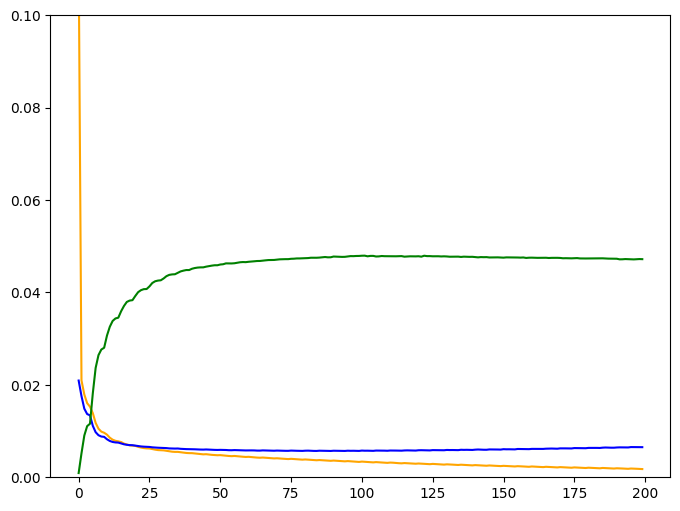

In [11]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(200), training_loss_per_epoch, color = "orange")
plt.plot(np.arange(200), validation_loss_per_epoch, color = "blue")
# plt.plot(np.arange(100), validation_loss_main_per_epoch, color= "red")
# plt.plot(np.arange(100), validation_loss_side_per_epoch, color = "purple")
plt.plot(np.arange(200), validation_map_per_epoch/10, color = "green")
#plt.hlines(0.010051161982119083, 0, 100 , colors=['black'],linestyles=['dotted'])
plt.ylim(0,0.1)
plt.plot()

In [12]:
np.argmax(validation_map_per_epoch)

101

In [13]:
np.argmin(validation_loss_per_epoch)

89